In [2]:
%load_ext autoreload
%notebook autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import geopandas as gpd
from scipy.spatial import KDTree
from tqdm.autonotebook import tqdm
from scipy.ndimage import gaussian_filter
from fuzzywuzzy import process
import contextily as cx

import warnings

from IndexUtils import * 
from TileUtils import *
from featurematching import *

# TILED INFERENCE
import sahi
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict
from scipy.spatial.distance import cdist

from scipy.fftpack import fft2, ifft2, fftshift
from scipy.ndimage import center_of_mass

from sklearn.cluster import DBSCAN

from skimage.morphology import skeletonize

from scipy.interpolate import Rbf


C:\Users\fhacesga\AppData\Local\Temp\ipykernel_7088\3338012589.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


In [4]:
corners = gpd.read_file(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\OSM_Roads\TexasRoads_filtered_strict_3857_nondupe_smaller_harris.gpkg")
roads_gdf = gpd.read_file(r"C:\Users\fhacesga\Downloads\TexasRoads_filtered_strict_3857.gpkg", engine='pyogrio', use_arrow=True)

corner_dir = r"D:\RECTDNN\processing\2024-10-11_15-08-46\street_corners\exp4\pickles\\"

output_dir = r"D:\RECTDNN\processing\2024-10-11_15-08-46\registration\\"

descriptor_kwds = {
    "angle_step"        : 5,
    "azimuth_radius"    : 500
}

corners, _ = calcDescriptors(corners, **descriptor_kwds)

  0%|          | 0/127256 [00:00<?, ?it/s]

In [5]:
with open("SmartDictV2.p", 'rb') as f:
    tile_coords = pickle.load(f)

In [6]:
# r"D:\RECTDNN\processing\2024-10-11_15-08-46\referencing\48201C0930J.tif"
# tile_name = f"48201C0660L"
# tile_name = f"48201C0930J"
tile_name = f"48201C0530J"
# tile_name = f"48201C0150G"

with open(f"{corner_dir}{tile_name}.pickle", 'rb') as f:
    x = pickle.load(f)    
    corner_bbox = [a.bbox.to_xyxy() for a in x if a.score.value > 0.001]
    corner_arry = np.array([calcCenter(a) for a in corner_bbox ]) * 2
    print(f"{len(corner_bbox)} / {len(x)}")

im_file    = r"D:\RECTDNN\processing\2024-10-11_15-08-46\referencing\\" + tile_name + ".tif"
him_file   = r"D:\RECTDNN\processing\2024-10-11_15-08-46\half_size\\" + tile_name + ".tif"

curr_tn = os.path.basename(im_file.split(".")[0])[:-1]
curr_tf = os.path.basename(im_file.split(".")[0])[-1]

ra = rio.open(im_file)
bounds  = ra.bounds
image   = ra.read(1)

bounds, RLNN = findBounds(im_file, None)

if len(bounds[0]) < 1:
    print(f"COULD NOT FIND BOUNDS, USING IMAGE EXTENTS {tile_name}")
    bbox = [0, 0, image.shape[0], image.shape[1]]
else:
    bbox = bounds[0].boxes.xyxy.numpy().astype(np.int32)[0].flatten()

current_tile_coords = tile_coords.get(curr_tn, None)
if current_tile_coords is None:
    raise(Exception(f"Could not find tile in detections {curr_tn}"))

current_tf_coords = current_tile_coords.get(curr_tf, None)
if current_tf_coords is None:
    # warnings.warn(f"Could not find tile extension in detections {curr_tn} - {curr_tf}, using default")
    print(f"Could not find tile extension in detections {curr_tn} - {curr_tf}, using default {list(current_tile_coords.keys())[0]} from options {current_tile_coords.keys()}")
    curr_tf = list(current_tile_coords.keys())[0]
    

# real_x, real_y = bbox_to_coords_realworld(tile_coords[curr_tn][curr_tf]["coords"][0])
real_x, real_y = bbox_to_coords_realworld(tile_coords[curr_tn][curr_tf]["coords"][0])
pic_x, pic_y   = bbox_to_coords_raster(bbox)

affine = affineTransformation(pic_x, pic_y, real_x, real_y)

# corner_arry = streetcorners[os.path.basename(tile).split(".")[0] + ".pickle"] * 2# streetresults_struct[tile_coords[out_name]['input_file']]
corner_arry = np.int32(corner_arry)                 # CONVERT TO INT32
corner_arry = cleanCenterBBOX(corner_arry, bbox)

# USE RASTER TRANSFORM TO GET REAL-WORLD ESTIMATES OF STREET CORNERS
im_corner_gdf = pointsToGeodataFrame(ra, corner_arry[:, 1], corner_arry[:, 0])

bounds_poly = enlarged_bounds(ra, n=2)

corners_curr = gpd.clip(corners, bounds_poly)

134 / 134
Could not find tile extension in detections 48201C0530 - J, using default 0 from options dict_keys([0, 'L'])


<Axes: >

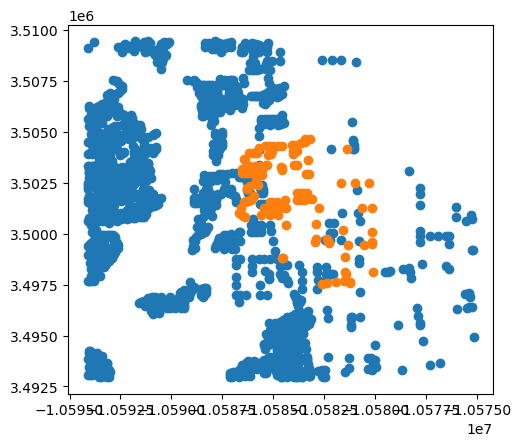

In [7]:
fig, ax =plt.subplots()

corners_curr.plot(ax=ax)
im_corner_gdf.plot(ax=ax)

In [14]:
def calcQuiver(ax, fromGDF, toGDF, color="black"):
    fromcoords = np.vstack((np.array(fromGDF.geometry.x), np.array(fromGDF.geometry.y))).T
    tocoords = np.vstack((np.array(toGDF.geometry.x), np.array(toGDF.geometry.y))).T

    uv = tocoords - fromcoords
    ax.quiver(fromcoords[:, 0], fromcoords[:, 1], uv[:, 0], uv[:, 1], angles='xy', color=color)

    return ax, uv

def plotMatches(fromPoints, toPoints):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))

    fromPoints.plot(ax=axs[0])
    toPoints.plot(ax=axs[0])
    axs[0], uv = calcQuiver(axs[0], fromPoints, toPoints, color="black")

    cx.add_basemap(axs[0])

    angles = np.degrees(np.arctan2(uv[:, 1], uv[:, 0]))
    test = np.vstack((normArry(angles), normArry(np.sqrt(uv[:, 0] ** 2, uv[:, 1] ** 2 )))).T
    idx = most_popular_indices_2d(test, eps=0.04)

    axs[0], uv = calcQuiver(axs[0], fromPoints.iloc[idx], toPoints.iloc[idx], color="yellow")

    bins = np.linspace(-180, 180, 100)

    axs[1].hist(angles, bins)
    axs[1].hist(angles[idx], bins)

    return fig, axs, uv, idx

def iterativeAdjustFromMatching(matchresults, corners_curr=None, idx=None, im_corner_gdf=None, plot=False, verbose=False):
    if idx is None:
        idx = np.arange(len(matchresults), dtype=np.int32)
    
    if len(matchresults[0]) > 4:
        fromPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[4][0] for x in matchresults], [x[4][1] for x in matchresults]))
        toPoints   = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[5][0] for x in matchresults], [x[5][1] for x in matchresults]))
    else:
        fromPoints = np.vstack((np.array(corners_curr.iloc[np.array(matchresults)[idx, 1]].geometry.x), np.array(corners_curr.iloc[np.array(matchresults)[idx, 1]].geometry.y))).T
        toPoints = np.vstack((np.array(im_corner_gdf.iloc[np.array(matchresults)[idx, 0]].geometry.x), np.array(im_corner_gdf.iloc[np.array(matchresults)[idx, 0]].geometry.y))).T
        fromPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy(fromPoints[:, 0], fromPoints[:, 1]))
        toPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy(toPoints[:, 0], toPoints[:, 1]))

    if plot:
        plotMatches(fromPoints, toPoints)

    """
    initial = affineTransformation(fromPoints.iloc[idx].geometry.x.to_numpy(), 
                                    fromPoints.iloc[idx].geometry.y.to_numpy(), 
                                    toPoints.iloc[idx].geometry.x.to_numpy(), 
                                    toPoints.iloc[idx].geometry.y.to_numpy(), verbose=False)
    matrix = initial.matrix"""
    coordsA = getCoordsGDF(fromPoints)
    coordsB = getCoordsGDF(toPoints)

    coordsA, coordsB = normCoords(coordsA, coordsB)

    checker = True
    prev = np.where(idx)[0].shape[0]

    while checker:
        initial = affineTransformation(coordsA[idx, 0], coordsA[idx, 1], coordsB[idx, 0], coordsB[idx, 1],verbose=False)
        matrix = initial.matrix        
        coordsBprime = np.hstack((coordsB[idx], np.ones((coordsB[idx].shape[0], 1)))) @ np.linalg.inv(matrix).T
        distances = np.sqrt((coordsBprime[:, 0] - coordsA[idx, 0]) ** 2 + (coordsBprime[:, 1] - coordsA[idx, 1]) ** 2)
        uv = coordsB - coordsA
        angles = np.degrees(np.arctan2(uv[:, 1], uv[:, 0]))
        test = np.vstack((normArry(angles), normArry(np.sqrt(uv[:, 0] ** 2, uv[:, 1] ** 2 )))).T
        test[np.isnan(test)] = 0
        idx = most_popular_indices_2d(test, eps=0.01)

        if np.where(idx)[0].shape[0] < prev:
            prev = np.where(idx)[0].shape[0]
        else: 
            checker = False
        
        if verbose:

            fig, axs = plt.subplots(1, 2)
            axs[0].scatter(coordsA[idx, 0], coordsA[idx, 1], color='black')
            axs[0].scatter(coordsB[idx, 0], coordsB[idx, 1])
            axs[0].scatter(coordsBprime[:, 0], coordsBprime[:, 1], marker='x')
            axs[1].hist(distances, bins=50)
            plt.show()

    return matrix, distances

def registerImagesV1(ra,im_corner_gdf, corners_curr, corner_arry, descriptor_kwds, r_initial=500, verbose=1, distance_threshold=2):
    compoundedAdjustment = np.eye(3)
    flip=np.array([
        [1, 0, 0],
        [0, -1, 0],
        [0, 0, 1]
        ]) 
    

    for i in range(20):
        
        r_current = r_initial * 0.9 ** i

        if i == 0:
            matching_results, im_corner_gdf, corners_curr = matching(im_corner_gdf, corners_curr, ratio_threshold=0.8, **descriptor_kwds)
            # return matching_results, im_corner_gdf, corners_curr
            matrix, distances = iterativeAdjustFromMatching(matching_results, corners_curr=corners_curr, im_corner_gdf=im_corner_gdf, plot=verbose>3)
        else:
            matching_results, _, _ = matching_distances(im_corner_gdf_adj, corners_curr, match_radius=r_current, **descriptor_kwds)
            matrix, distances = iterativeAdjustFromMatching(matching_results, plot=verbose>3)

        compoundedAdjustment = np.linalg.inv(matrix) @ compoundedAdjustment 

        rev_adj = compoundedAdjustment @ flip
        current_adjustment = getMatrixFromAffine(ra.transform) @ flip @ rev_adj

        reprojectedcorners = np.hstack((corner_arry, np.ones((corner_arry.shape[0], 1)))) @ current_adjustment.T

        if verbose > 5:
            print(rev_adj)

        if verbose > 10:
            plt.figure()
            plt.scatter(reprojectedcorners[:, 0], reprojectedcorners[:, 1])
            test = np.hstack((corner_arry, np.ones((corner_arry.shape[0], 1)))) @  getMatrixFromAffine(ra.transform).T
            plt.scatter(test[:, 0], test[:, 1])
            plt.show()

        im_corner_gdf_adj = im_corner_gdf.copy()
        im_corner_gdf_adj['geometry'] = gpd.points_from_xy(reprojectedcorners[:,0], reprojectedcorners[:, 1])
        if verbose > 0:
            print(np.nanpercentile(distances, [0, 25, 50, 75, 100]), len(matching_results))

        if np.nanpercentile(distances, 50) < distance_threshold:
            return current_adjustment        

    return current_adjustment

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[[    0.99093    -0.01437       -2296]
 [-0.00031214     -1.0878     -1735.3]
 [          0           0           1]]
[     2.0283      2.6324      2.9099       3.796      4.4579] 39


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/1744 [00:00<?, ?it/s]

[[    0.99997 -0.00050503     -2456.7]
 [  0.0017085     -1.0849     -1576.1]
 [          0           0           1]]
[     1.2087      3.6328      4.3441      7.2556       13.97] 89


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/1744 [00:00<?, ?it/s]

[[     1.0003 -0.00021755     -2556.4]
 [  0.0011458     -1.0877     -1570.6]
 [          0           0           1]]
[    0.62091      3.1988      4.9507      7.1462      13.303] 84


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/1744 [00:00<?, ?it/s]

[[    0.99985 -1.8812e-05     -2569.3]
 [ 0.00057864     -1.0873     -1551.4]
 [          0           0           1]]
[     1.5367      3.1792       4.162      5.0521      8.9409] 79


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/1744 [00:00<?, ?it/s]

[[    0.99973  0.00010422     -2568.3]
 [-0.00019523     -1.0863     -1542.2]
 [          0           0           1]]
[    0.80152      1.3877      1.9702      2.1187      2.3306] 76
[[-0.00024215  9.1778e-05     -2261.8]
 [-0.00015865   -0.070118     -1253.2]
 [          0           0           0]]


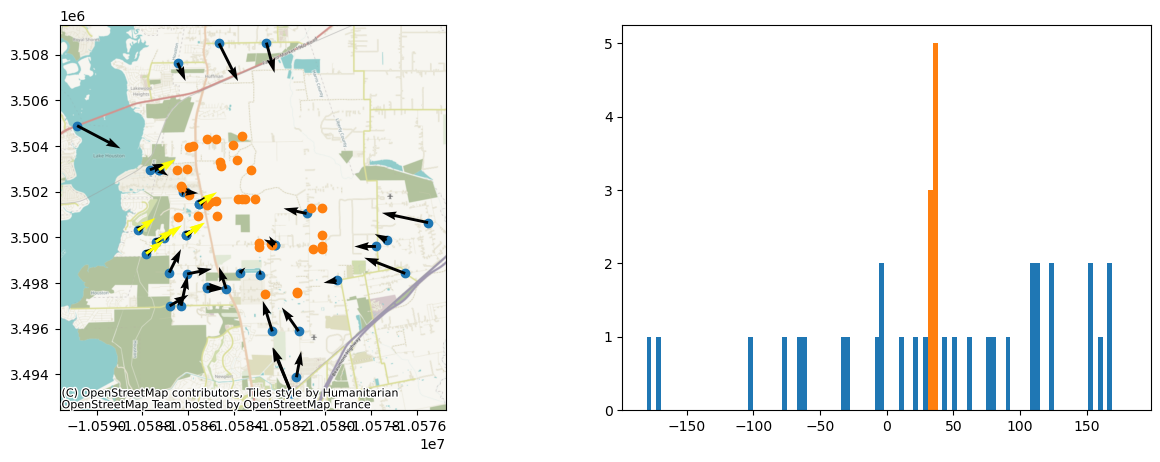

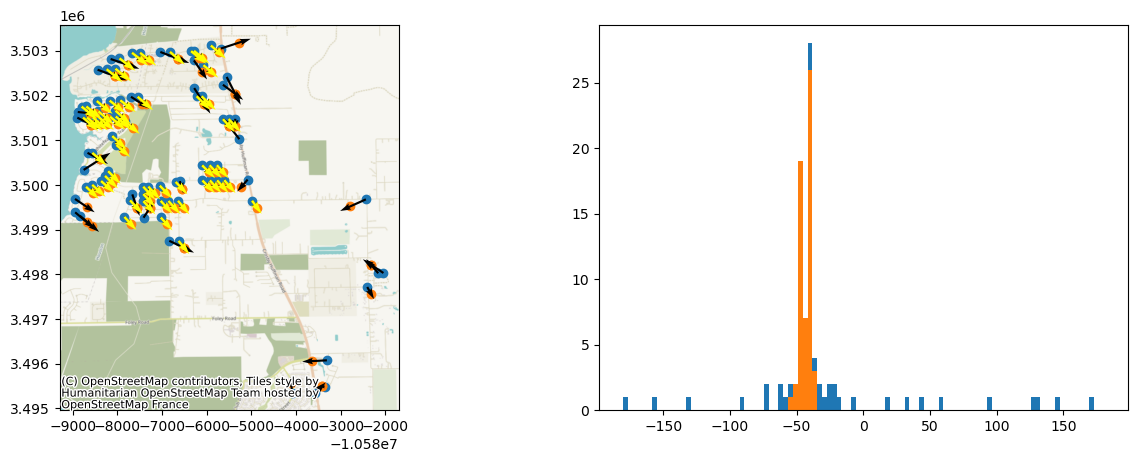

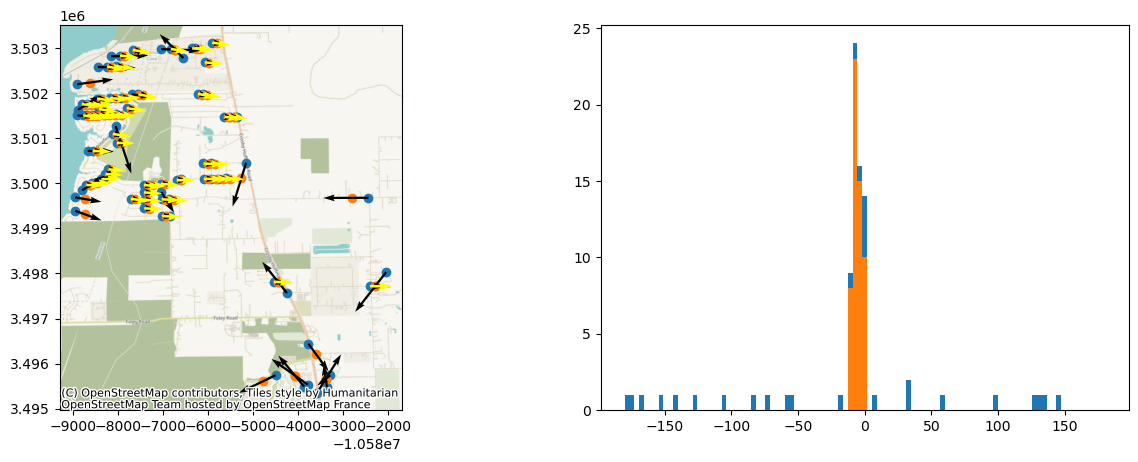

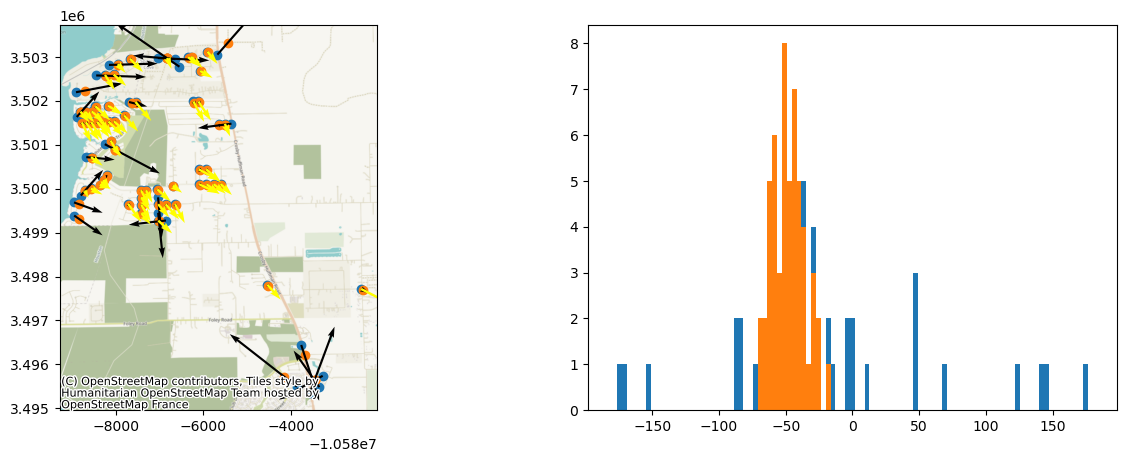

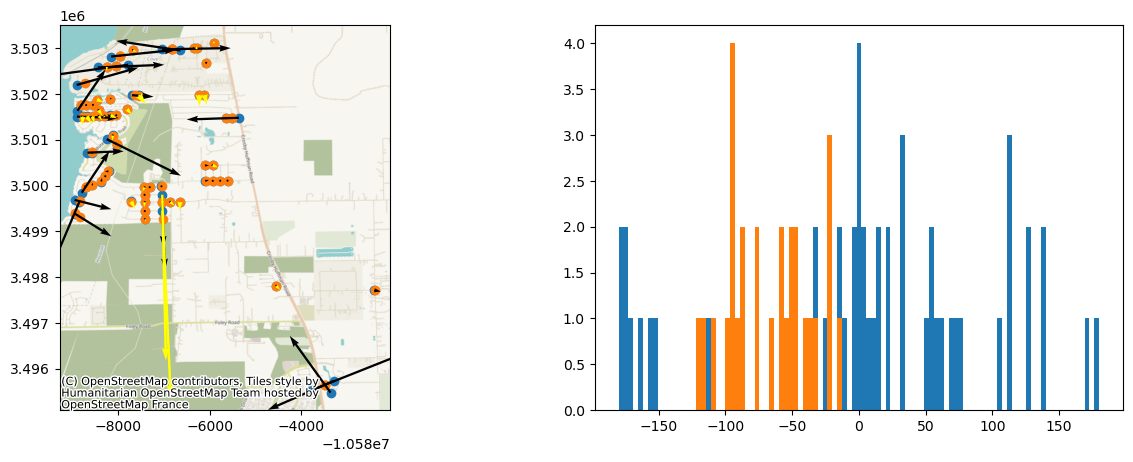

In [15]:
prev_transform = getMatrixFromAffine(ra.transform)

current_adjustment = registerImagesV1(ra, im_corner_gdf, corners_curr, corner_arry, descriptor_kwds, verbose=10)

print(current_adjustment - prev_transform)

with rio.open(f"{output_dir}{tile_name}.tif", 'w',
                driver='GTiff', count=1, dtype=np.uint8,
                height=image.shape[0], width=image.shape[1],
                crs=f'EPSG:3857',
                transform=rio.Affine(*current_adjustment.flatten()[:6])) as dst:
                    dst.write(image, 1) 